In [1]:
##--------------------------------------##
##                Imports               ##
##--------------------------------------##

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import torchvision.transforms as transforms
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score

In [2]:
##--------------------------------------##
##        MNIST Dataset Preparing       ##
##--------------------------------------##

(x_train, y_train), (x_val, y_val) = tf.keras.datasets.mnist.load_data()
x_train, x_val = x_train / 255.0, x_val / 255.0  # Normalize to [0, 1]

x_train = torch.tensor(x_train.reshape(-1, 28*28), dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
x_val = torch.tensor(x_val.reshape(-1, 28*28), dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.long)

train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Split the original validation dataset into validation and test sets
val_size = len(val_dataset) // 2
test_size = len(val_dataset) - val_size
val_dataset, test_dataset = random_split(val_dataset, [val_size, test_size])

val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [3]:
##-------------------------------------------##
##             Model building                ##
##-------------------------------------------##

class SimpleNet(nn.Module):
    def __init__(self, num_features):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(num_features, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)  # 10 classes for MNIST

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [4]:
##-------------------------------------------##
##           Optimizer defining              ##
##-------------------------------------------##

class ModifiedAdam(torch.optim.Optimizer):
    def __init__(self, params, lr=0.005, beta1=0.8, beta2=0.99, eps=1e-8):
        defaults = dict(lr=lr, beta1=beta1, beta2=beta2, eps=eps)
        super(ModifiedAdam, self).__init__(params, defaults)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                state = self.state[p]

                if len(state) == 0:
                    state['v'] = torch.zeros_like(p.data)
                    state['k'] = torch.zeros_like(p.data)

                v, k = state['v'], state['k']
                beta1, beta2, eps, lr = group['beta1'], group['beta2'], group['eps'], group['lr']

                v.mul_(beta1).add_(grad, alpha=1 - beta1)
                k.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

                lookahead_grad = grad - beta1 * v
                p.data.addcdiv_(lookahead_grad, torch.sqrt(k) + eps, value=-lr)

        return loss

In [5]:
##-------------------------------------------##
##        Training model function            ##
##-------------------------------------------##

def train_model_with_metrics(model, optimizer, train_loader, val_loader, test_loader, num_epochs=50):
    criterion = nn.CrossEntropyLoss()
    train_losses, val_losses, test_losses = [], [], []
    train_accuracies, val_accuracies, test_accuracies = [], [], []
    train_f1_scores, val_f1_scores, test_f1_scores = [], [], []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_train_loss = 0.0
        all_train_targets, all_train_preds = [], []

        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()

            # Collect predictions and targets for metrics
            _, preds = torch.max(outputs, 1)
            all_train_preds.extend(preds.cpu().numpy())
            all_train_targets.extend(targets.cpu().numpy())

        # Calculate metrics for training
        train_losses.append(running_train_loss / len(train_loader))
        train_accuracies.append(accuracy_score(all_train_targets, all_train_preds))
        train_f1_scores.append(f1_score(all_train_targets, all_train_preds, average='macro'))

        # Validation phase
        model.eval()
        running_val_loss = 0.0
        all_val_targets, all_val_preds = [], []

        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                running_val_loss += loss.item()

                # Collect predictions and targets for metrics
                _, preds = torch.max(outputs, 1)
                all_val_preds.extend(preds.cpu().numpy())
                all_val_targets.extend(targets.cpu().numpy())

        # Calculate metrics for validation
        val_losses.append(running_val_loss / len(val_loader))
        val_accuracies.append(accuracy_score(all_val_targets, all_val_preds))
        val_f1_scores.append(f1_score(all_val_targets, all_val_preds, average='macro'))

        # Test phase
        running_test_loss = 0.0
        all_test_targets, all_test_preds = [], []

        with torch.no_grad():
            for inputs, targets in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                running_test_loss += loss.item()

                # Collect predictions and targets for metrics
                _, preds = torch.max(outputs, 1)
                all_test_preds.extend(preds.cpu().numpy())
                all_test_targets.extend(targets.cpu().numpy())

        # Calculate metrics for testing
        test_losses.append(running_test_loss / len(test_loader))
        test_accuracies.append(accuracy_score(all_test_targets, all_test_preds))
        test_f1_scores.append(f1_score(all_test_targets, all_test_preds, average='macro'))

    return (
        train_losses, val_losses, test_losses,
        train_accuracies, val_accuracies, test_accuracies,
        train_f1_scores, val_f1_scores, test_f1_scores
    )

def create_optimizer(opt_name, model):
    if opt_name == "ModifiedAdam":
        return ModifiedAdam(model.parameters())
    elif opt_name == "Adam":
        return optim.Adam(model.parameters())
    elif opt_name == "RMSprop":
        return optim.RMSprop(model.parameters())

In [8]:
##-------------------------------------------##
##              Training model               ##
##-------------------------------------------##

optimizers = ["ModifiedAdam", "Adam", "RMSprop"]
num_epochs = 50
results = {}

for opt_name in optimizers:
    model = SimpleNet(num_features=28*28)  # MNIST images are 28x28
    optimizer = create_optimizer(opt_name, model)
    metrics = train_model_with_metrics(
        model, optimizer, train_loader, val_loader, test_loader, num_epochs=num_epochs
    )
    results[opt_name] = {
        'train_loss': metrics[0], 
        'val_loss': metrics[1],
        'test_loss': metrics[2],
        'train_accuracy': metrics[3],
        'val_accuracy': metrics[4],
        'test_accuracy': metrics[5],
        'train_f1': metrics[6],
        'val_f1': metrics[7],
        'test_f1': metrics[8]
    }
    print(f"{opt_name} training completed.")


ModifiedAdam training completed.
Adam training completed.
RMSprop training completed.


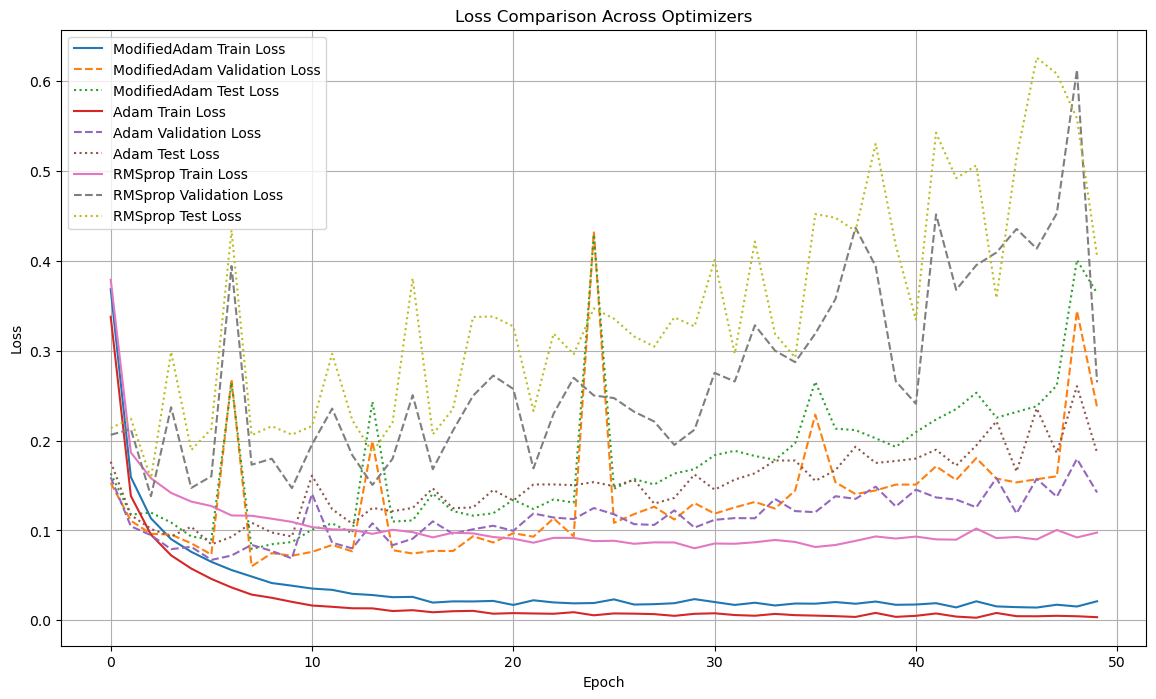

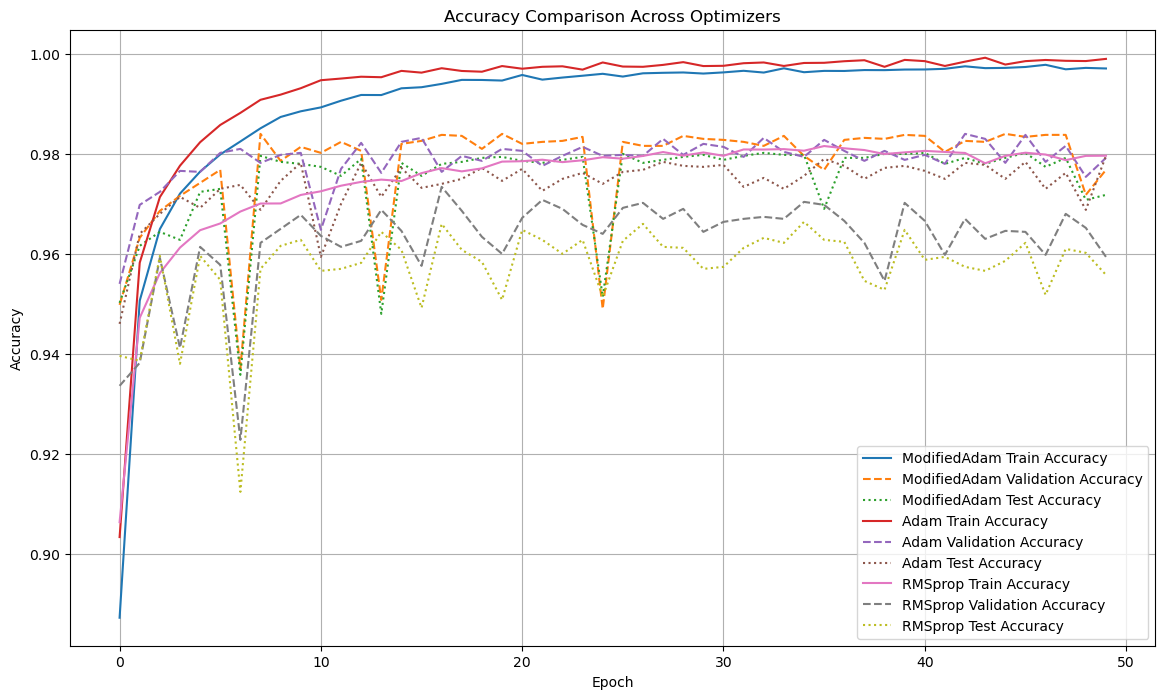

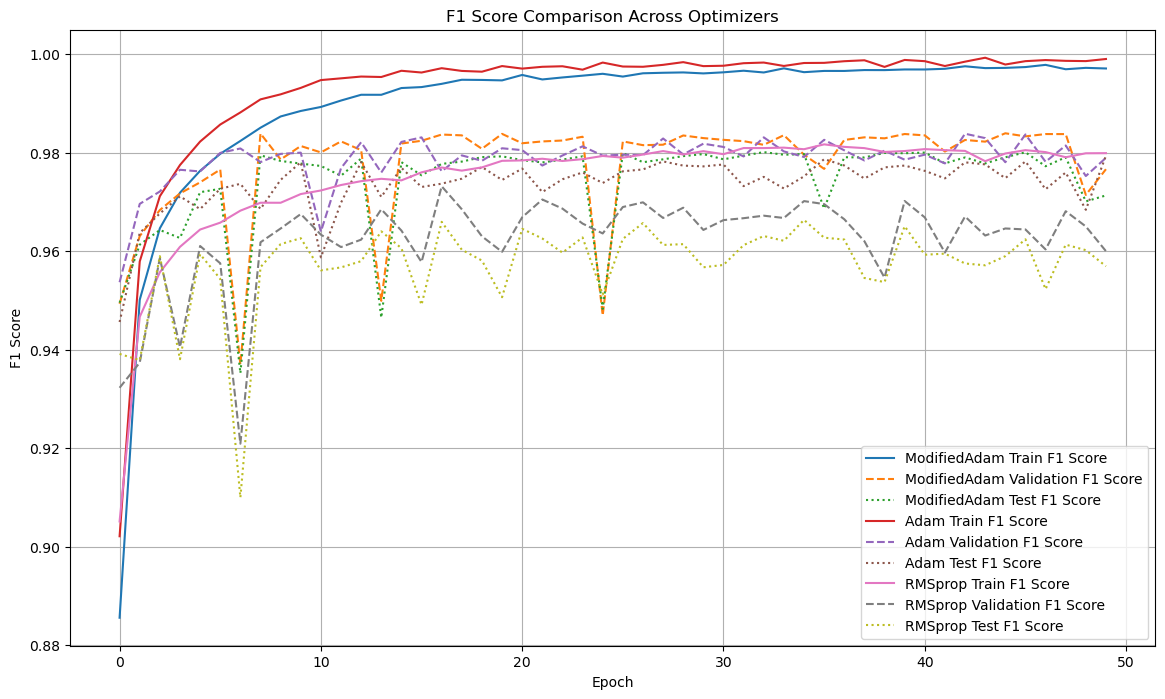

In [9]:
##-------------------------------------------##
##                 Plotting                  ##
##-------------------------------------------##

metrics_to_plot = {
    'Loss': ['train_loss', 'val_loss', 'test_loss'],
    'Accuracy': ['train_accuracy', 'val_accuracy', 'test_accuracy'],
    'F1 Score': ['train_f1', 'val_f1', 'test_f1']
}

for metric_name, metric_keys in metrics_to_plot.items():
    plt.figure(figsize=(14, 8))
    for opt_name, metrics in results.items():
        plt.plot(metrics[metric_keys[0]], label=f"{opt_name} Train {metric_name}")
        plt.plot(metrics[metric_keys[1]], label=f"{opt_name} Validation {metric_name}", linestyle='--')
        plt.plot(metrics[metric_keys[2]], label=f"{opt_name} Test {metric_name}", linestyle=':')

    plt.xlabel("Epoch")
    plt.ylabel(metric_name)
    plt.title(f"{metric_name} Comparison Across Optimizers")
    plt.legend()
    plt.grid(True)
    plt.show()


In [10]:
##-------------------------------------------##
##                 Summary                   ##
##-------------------------------------------##

for opt_name, metrics in results.items():
    min_train_loss = min(metrics['train_loss'])
    min_val_loss = min(metrics['val_loss'])
    min_test_loss = min(metrics['test_loss'])
    max_train_accuracy = max(metrics['train_accuracy'])
    max_val_accuracy = max(metrics['val_accuracy'])
    max_test_accuracy = max(metrics['test_accuracy'])
    max_train_f1 = max(metrics['train_f1'])
    max_val_f1 = max(metrics['val_f1'])
    max_test_f1 = max(metrics['test_f1'])

    print(f"{opt_name} - Min Train Loss: {min_train_loss:.4f}, Min Val Loss: {min_val_loss:.4f}, Min Test Loss: {min_test_loss:.4f}")
    print(f"{opt_name} - Max Train Accuracy: {max_train_accuracy:.4f}, Max Val Accuracy: {max_val_accuracy:.4f}, Max Test Accuracy: {max_test_accuracy:.4f}")
    print(f"{opt_name} - Max Train F1 Score: {max_train_f1:.4f}, Max Val F1 Score: {max_val_f1:.4f}, Max Test F1 Score: {max_test_f1:.4f}")


ModifiedAdam - Min Train Loss: 0.0142, Min Val Loss: 0.0600, Min Test Loss: 0.0793
ModifiedAdam - Max Train Accuracy: 0.9978, Max Val Accuracy: 0.9840, Max Test Accuracy: 0.9802
ModifiedAdam - Max Train F1 Score: 0.9978, Max Val F1 Score: 0.9839, Max Test F1 Score: 0.9801
Adam - Min Train Loss: 0.0028, Min Val Loss: 0.0672, Min Test Loss: 0.0845
Adam - Max Train Accuracy: 0.9992, Max Val Accuracy: 0.9840, Max Test Accuracy: 0.9796
Adam - Max Train F1 Score: 0.9992, Max Val F1 Score: 0.9838, Max Test F1 Score: 0.9793
RMSprop - Min Train Loss: 0.0801, Min Val Loss: 0.1381, Min Test Loss: 0.1576
RMSprop - Max Train Accuracy: 0.9816, Max Val Accuracy: 0.9734, Max Test Accuracy: 0.9664
RMSprop - Max Train F1 Score: 0.9817, Max Val F1 Score: 0.9731, Max Test F1 Score: 0.9663
